# Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Import Datasets

In [2]:
train_csv_url = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-10/train.csv"
valid_csv_url = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-10/valid.csv"
test_csv_url = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-10/test.csv"

train_data = pd.read_csv(train_csv_url)
valid_data = pd.read_csv(valid_csv_url)
test_data = pd.read_csv(test_csv_url)

print("Train data:")
print(train_data.head())
print("Valid data:")
print(valid_data.head())
print("Test data:")
print(test_data.head())

Train data:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  -0.027083   0.072947  -0.093659   0.053418  -0.085516  -0.102610   
1   0.070195   0.228641  -0.132860  -0.077761  -0.054993  -0.210365   
2   0.164312   0.052808  -0.058510   0.104724  -0.025886  -0.101427   
3   0.029730   0.113737   0.061113  -0.099329  -0.111600  -0.245942   
4   0.031364   0.142409  -0.160743  -0.076594  -0.062412  -0.264732   

   feature_7  feature_8  feature_9  feature_10  ...  feature_763  feature_764  \
0  -0.021217   0.016162  -0.184269    0.110335  ...    -0.183643     0.091299   
1   0.127747  -0.132385  -0.161366    0.172764  ...    -0.123668     0.029626   
2  -0.047177   0.091298  -0.094569    0.088062  ...     0.075410     0.070125   
3   0.086520   0.071996   0.028319    0.207910  ...    -0.062511    -0.226912   
4   0.079197   0.026060  -0.217023    0.084656  ...    -0.193882     0.107297   

   feature_765  feature_766  feature_767  feature_768  label_1  label_2  \

# Data Visualization

In [ ]:
def visualize_label(y, title, x_title, y_title='Number of entries'):
  unique_classes, class_counts = np.unique(y, return_counts=True)
  plt.bar(unique_classes, class_counts)
  plt.xlabel(x_title)
  plt.ylabel(y_title)
  plt.title(title)
  plt.show()

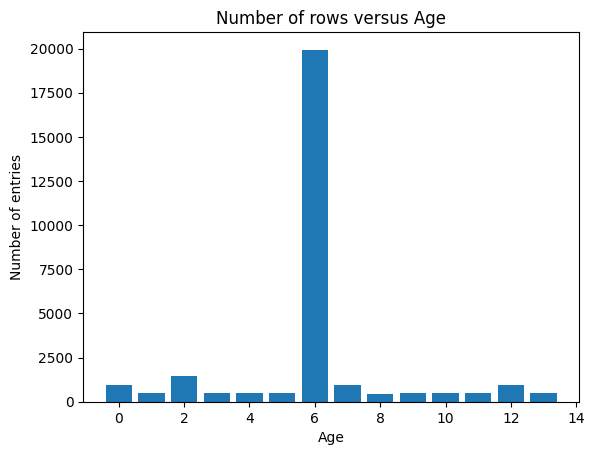

In [ ]:
visualize_label(train_data['label_4'], "Number of rows versus Age","Age")

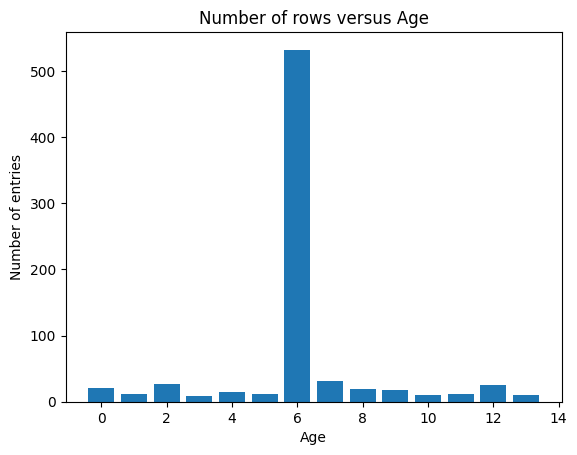

In [ ]:
visualize_label(valid_data['label_4'], "Number of rows versus Age","Age")

# Outlier Detection and Removal

In [3]:
from scipy.stats import norm

def visualize_label_norm(y, title, x_title, y_title='Number of entries'):
  unique_classes, class_counts = np.unique(y, return_counts=True)
  plt.bar(unique_classes, class_counts)
  plt.xlabel(x_title)
  plt.ylabel(y_title)
  plt.title(title)

  rng = np.arange(train_data["label_4"].min(), train_data["label_4"].max(), 0.1)
  plt.plot(rng, norm.pdf(rng,train_data["label_4"].mean(),train_data["label_4"].std()))
  plt.show()

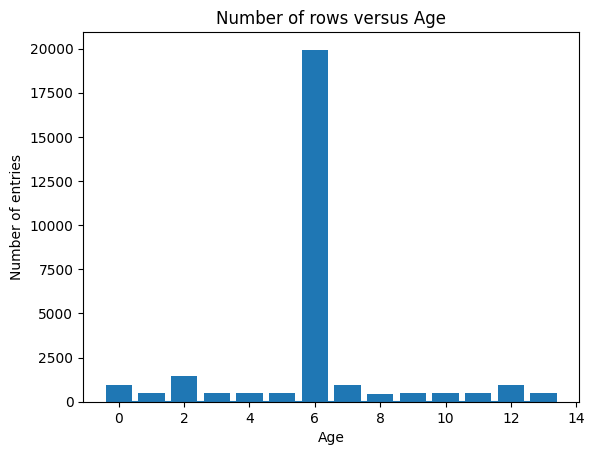

In [4]:
visualize_label_norm(train_data['label_4'], "Number of rows versus Age","Age")

In [5]:
train_data['zscore'] = ( train_data["label_4"] - train_data["label_4"].mean() ) / train_data["label_4"].std()
outliers = train_data[(train_data.zscore<-3) | (train_data.zscore>3)]
outliers.shape

(0, 773)

No outliers to remove

# Train without Feaure Reduction

In [6]:
print(f"train_data dataset shape {train_data.shape}")
print(f"# of missing values {train_data['label_4'].isna().sum()}")
print(f"# of labels {train_data['label_4'].value_counts().shape[0]}")
print(f"label summary\n{train_data['label_4'].value_counts()}")

train_data dataset shape (28520, 773)
# of missing values 0
# of labels 14
label summary
6     19938
2      1449
0       955
12      954
7       938
13      482
1       481
11      480
10      480
3       479
5       478
9       472
4       469
8       465
Name: label_4, dtype: int64


In [7]:
train_data.dropna(subset=['label_4'], inplace=True)
print(f"train_data dataset shape {train_data.shape}")

train_data dataset shape (28520, 773)


Feature Enginering

*   Label_4 has no missing values
*   Label_4 has 14 unique classes
*   Using one-hot encoding for multilabel classification



In [8]:
label_4 = train_data['label_4'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_4)
print(ohe.categories_)

label_4 = ohe.transform(label_4)
print(label_4)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:, :768], label_4, test_size=0.2, stratify=label_4, random_state=2023)

In [10]:
X_train_tensors = torch.tensor(X_train.iloc[:, :].values, dtype=torch.float32)
print(X_train_tensors.shape)

X_test_tensors = torch.tensor(X_test.iloc[:, :].values, dtype=torch.float32)
print(X_test_tensors.shape)

torch.Size([22816, 768])
torch.Size([5704, 768])


## Define the Model

In [11]:
class AccentClassifier(nn.Module):
    def __init__(self, dropout_prob=0.5, weight_decay=1e-5):
        super(AccentClassifier, self).__init__()
        self.linear1 = nn.Linear(768, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 14)

        # Set weight_decay for regularization
        self.weight_decay = weight_decay

    def forward(self, tensors):
        output_l1 = torch.relu(self.linear1(tensors))
        output_l2 = torch.relu(self.linear2(output_l1))
        output_l3 = torch.relu(self.linear3(output_l2))
        output_l4 = self.linear4(output_l3)
        return output_l4

    def l2_regularization_loss(self):
        # Calculate L2 regularization loss for linear layers
        l2_loss = 0.0
        for param in self.parameters():
            if param.requires_grad:
                l2_loss += torch.norm(param, 2)
        return self.weight_decay * l2_loss

## Train the model

In [12]:
# Create an instance of the AccentClassifier model
accentClassifier = AccentClassifier()

# Define a cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Create a DataLoader for batching
batch_size = 128
dataset = TensorDataset(X_train_tensors, torch.tensor(y_train))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define an optimizer
optimizer = torch.optim.Adam(accentClassifier.parameters(), lr=0.0001)

# Define early stopping parameters
patience = 50
best_validation_accuracy = 0
no_improvement_counter = 0

# Training loop
epochs = 1000
for epoch in range(epochs):

    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = accentClassifier(inputs)

        ce_loss = criterion(outputs, targets)
        l2_loss = accentClassifier.l2_regularization_loss()

        total_loss = ce_loss + l2_loss

        total_loss.backward()
        optimizer.step()

    # Validation step (evaluate on validation dataset)
    with torch.no_grad():
        accentClassifier.eval()
        y_test_pred = accentClassifier(X_test_tensors)
        ce = criterion(y_test_pred, torch.tensor(y_test))
        acc = (torch.argmax(y_test_pred, 1) == torch.argmax(torch.tensor(y_test), 1)).float().mean()
        accentClassifier.train()

    print(f"Epoch {epoch} validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

    # Check for early stopping
    if acc > best_validation_accuracy:
        best_validation_accuracy = acc
        no_improvement_counter = 0
        # Save the trained best model if needed
        torch.save(accentClassifier.state_dict(), 'accentClassifier_model.pth')
    else:
        no_improvement_counter += 1

    # If no improvement for 'patience' consecutive epochs, stop training
    if no_improvement_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

Epoch 0 validation: Cross-entropy=1.3184365925848025, Accuracy=0.6991584897041321
Epoch 1 validation: Cross-entropy=1.238902954570492, Accuracy=0.6991584897041321
Epoch 2 validation: Cross-entropy=1.153851132191572, Accuracy=0.6996844410896301
Epoch 3 validation: Cross-entropy=1.0820726053227667, Accuracy=0.7077489495277405
Epoch 4 validation: Cross-entropy=0.9620413442104073, Accuracy=0.7247545719146729
Epoch 5 validation: Cross-entropy=0.8478176802202809, Accuracy=0.7424614429473877
Epoch 6 validation: Cross-entropy=0.7508430731537625, Accuracy=0.7634993195533752
Epoch 7 validation: Cross-entropy=0.6761403523612125, Accuracy=0.7861149907112122
Epoch 8 validation: Cross-entropy=0.6292347855782205, Accuracy=0.8152173757553101
Epoch 9 validation: Cross-entropy=0.5605822341242135, Accuracy=0.8245091438293457
Epoch 10 validation: Cross-entropy=0.5194549528223745, Accuracy=0.8357293009757996
Epoch 11 validation: Cross-entropy=0.48661558842933683, Accuracy=0.8492286205291748
Epoch 12 valida

In [13]:
# Create an instance of the model
accentClassifier = AccentClassifier()

# Load the saved model state dictionary
accentClassifier.load_state_dict(torch.load('/content/drive/Shareddrives/test/ML _Project/Layer_10/accentClassifier_model.pth'))

# Validation step (evaluate on validation dataset)
with torch.no_grad():
    accentClassifier.eval()
    y_test_pred = accentClassifier(X_test_tensors)
    ce = criterion(y_test_pred, torch.tensor(y_test))
    acc = (torch.argmax(y_test_pred, 1) == torch.argmax(torch.tensor(y_test), 1)).float().mean()

print(f"Best model validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

Best model validation: Cross-entropy=0.17598358512368434, Accuracy=0.9724754691123962


## Evaluation of the Model

In [14]:
valid_data.dropna(subset=['label_4'], inplace=True)
print(f"valid_data dataset shape {valid_data.shape}")

valid_data dataset shape (750, 772)


In [15]:
label_4_eval = valid_data['label_4'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_4_eval)
print(ohe.categories_)

label_4_eval = ohe.transform(label_4_eval)
print(label_4_eval)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
# Set your model to evaluation mode
accentClassifier.eval()

X_valid_tensors = torch.tensor(valid_data.iloc[:, :768].values, dtype=torch.float32)
print(X_valid_tensors.shape)

y_pred = accentClassifier(X_valid_tensors)
ce = criterion(y_pred, torch.tensor(label_4_eval))
acc = (torch.argmax(y_pred, 1) == torch.argmax(torch.tensor(label_4_eval), 1)).float().mean()
print(f"Cross-entropy={float(ce)}, Test Accuracy={float(acc)}")

torch.Size([750, 768])
Cross-entropy=0.15853531938960866, Test Accuracy=0.9773333072662354


In [17]:
valid_data_c = valid_data.copy()

y_pred_one_hot = ohe.inverse_transform(y_pred.detach().numpy())
valid_data_c["label_4_pred"] = pd.DataFrame(y_pred_one_hot, columns=["label_4_pred"])

In [18]:
valid_data_c.iloc[:, 771:].head(100)

,label_4,label_4_pred
0,6,6
1,6,6
2,6,6
3,6,6
4,6,6
...,...,...
95,1,1
96,1,1
97,1,1
98,6,6


In [19]:
y_pred_labels = torch.argmax(y_pred, axis=1).numpy()
label_4_np = torch.argmax(torch.tensor(label_4_eval), axis=1).numpy()

confusion = confusion_matrix(label_4_np, y_pred_labels)
print(classification_report(label_4_np, y_pred_labels))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.92      1.00      0.96        11
           2       0.92      0.89      0.91        27
           3       1.00      1.00      1.00         8
           4       0.93      0.93      0.93        15
           5       1.00      0.91      0.95        11
           6       0.98      0.99      0.99       532
           7       0.97      0.97      0.97        32
           8       1.00      1.00      1.00        19
           9       0.94      0.88      0.91        17
          10       1.00      1.00      1.00        10
          11       1.00      0.82      0.90        11
          12       1.00      0.96      0.98        26
          13       1.00      1.00      1.00        10

    accuracy                           0.98       750
   macro avg       0.97      0.95      0.96       750
weighted avg       0.98      0.98      0.98       750



In [20]:
accuracy_score(label_4_np, y_pred_labels)

0.9773333333333334

## Fixing class imbalance

In [21]:
from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE()
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train)

print(X_train_balanced.shape)
print(y_train_balanced.shape)

(223300, 768)
(223300, 14)


In [22]:
y_train_balanced

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
# Create an instance of the AccentClassifier model
accentClassifierOverSample = AccentClassifier()

# Define a cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Create a DataLoader for batching
batch_size = 128
dataset = TensorDataset(torch.tensor(X_train_balanced.values, dtype=torch.float32), torch.tensor(y_train_balanced))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define an optimizer
optimizer = torch.optim.Adam(accentClassifierOverSample.parameters(), lr=0.001)

# Define early stopping parameters
patience = 25
best_validation_accuracy = 0
no_improvement_counter = 0

# Training loop
epochs = 1000
for epoch in range(epochs):

    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = accentClassifierOverSample(inputs)
        ce_loss = criterion(outputs, targets.float())
        l2_loss = accentClassifierOverSample.l2_regularization_loss()

        total_loss = ce_loss + l2_loss

        total_loss.backward()
        optimizer.step()

    # Validation step (evaluate on validation dataset)
    with torch.no_grad():
        accentClassifierOverSample.eval()
        y_test_pred = accentClassifierOverSample(X_test_tensors)
        ce = criterion(y_test_pred, torch.tensor(y_test))
        acc = (torch.argmax(y_test_pred, 1) == torch.argmax(torch.tensor(y_test), 1)).float().mean()
        accentClassifierOverSample.train()

    print(f"Epoch {epoch} validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

    # Check for early stopping
    if acc > best_validation_accuracy:
        best_validation_accuracy = acc
        no_improvement_counter = 0
        # Save the trained best model if needed
        torch.save(accentClassifierOverSample.state_dict(), 'accentClassifierOverSample_model.pth')
    else:
        no_improvement_counter += 1

    # If no improvement for 'patience' consecutive epochs, stop training
    if no_improvement_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

Epoch 0 validation: Cross-entropy=0.510732863331698, Accuracy=0.8302945494651794
Epoch 1 validation: Cross-entropy=0.22596752273740617, Accuracy=0.9374123215675354
Epoch 2 validation: Cross-entropy=0.2879634681039685, Accuracy=0.9153226017951965
Epoch 3 validation: Cross-entropy=0.28610151683576907, Accuracy=0.9356591701507568
Epoch 4 validation: Cross-entropy=0.3198143479875807, Accuracy=0.9202314019203186
Epoch 5 validation: Cross-entropy=0.2210933323973822, Accuracy=0.9591514468193054
Epoch 6 validation: Cross-entropy=0.2361135336114046, Accuracy=0.9538919925689697
Epoch 7 validation: Cross-entropy=0.22316527813817447, Accuracy=0.9554698467254639
Epoch 8 validation: Cross-entropy=0.21354184313370805, Accuracy=0.9619565010070801
Epoch 9 validation: Cross-entropy=0.2407794442314853, Accuracy=0.9573982954025269
Epoch 10 validation: Cross-entropy=0.2499607665044526, Accuracy=0.9593268036842346
Epoch 11 validation: Cross-entropy=0.20153424694457114, Accuracy=0.9689691662788391
Epoch 12 v

In [ ]:
# Create an instance of the model
accentClassifierOverSample = AccentClassifier()

# Load the saved model state dictionary
accentClassifierOverSample.load_state_dict(torch.load('/content/drive/Shareddrives/test/ML _Project/accentClassifierOverSample_model.pth'))

# Validation step (evaluate on validation dataset)
with torch.no_grad():
    accentClassifierOverSample.eval()
    y_test_pred = accentClassifierOverSample(X_test_tensors)
    ce = criterion(y_test_pred, torch.tensor(y_test))
    acc = (torch.argmax(y_test_pred, 1) == torch.argmax(torch.tensor(y_test), 1)).float().mean()

print(f"Best model validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

We get better results without oversampling

## Get Test Results

In [ ]:
# Set your model to evaluation mode
accentClassifier.eval()

X_t_tensors = torch.tensor(test_data.iloc[:, :768].values, dtype=torch.float32)
print(X_t_tensors.shape)

y_pred_t = accentClassifier(X_t_tensors)
print(y_pred_t.shape)


In [ ]:
y_pred_one_hot = ohe.inverse_transform(y_pred_t.detach().numpy())
test_data["label_4"] = pd.DataFrame(y_pred_one_hot, columns=["label_4"])

In [ ]:
test_data.head()

In [ ]:
file_path = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-10/label_4.csv"

# Save the DataFrame to a CSV file
test_data.to_csv(file_path, index=False)

# Train with Feature Engineering

In [ ]:
data_features = train_data.iloc[:, :768]

## Drop Constant Features Using Variance Threshold

In [ ]:
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(data_features)

VarianceThreshold(threshold=0)

In [ ]:
constant_columns = [column for column in data_features.columns
                    if column not in data_features.columns[var_thres.get_support()]]

print(constant_columns)

[]


There is no constant columns

## Drop Features Using Pearson Correlation

In [ ]:
data_features.corr()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
feature_1,1.000000,0.267338,0.071490,0.414422,0.036982,0.207898,0.118319,0.147709,0.368570,-0.190114,...,0.294503,0.016181,0.253096,-0.245060,0.423731,0.443474,0.216448,-0.372152,0.081136,0.266223
feature_2,0.267338,1.000000,-0.027042,0.004284,0.009556,-0.175189,0.118727,0.047381,0.146719,0.004041,...,0.036397,0.120084,0.058233,-0.095840,0.066372,0.357378,0.107098,0.008878,-0.021500,0.233835
feature_3,0.071490,-0.027042,1.000000,0.005692,0.187217,-0.184922,-0.071054,-0.217118,0.112494,-0.045269,...,-0.054550,0.048824,-0.087434,0.183482,-0.184763,-0.133512,-0.018046,0.164799,-0.030219,0.204483
feature_4,0.414422,0.004284,0.005692,1.000000,-0.017515,0.295999,-0.119338,0.077402,0.123430,-0.147437,...,0.402941,-0.048514,0.175835,-0.130880,0.364475,0.317812,0.156064,-0.313222,0.200493,0.071073
feature_5,0.036982,0.009556,0.187217,-0.017515,1.000000,-0.139041,-0.020940,-0.116694,0.187147,-0.095713,...,0.002091,0.094546,0.062270,0.143789,-0.263428,0.032675,-0.091599,0.159690,-0.051591,-0.072895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_764,0.443474,0.357378,-0.133512,0.317812,0.032675,0.202273,0.078858,0.117481,0.085433,-0.282476,...,0.192540,0.068779,0.145485,-0.230508,0.315251,1.000000,0.204746,-0.159590,0.181170,0.216180
feature_765,0.216448,0.107098,-0.018046,0.156064,-0.091599,-0.113032,-0.079667,0.106025,0.118023,-0.205155,...,0.213167,0.136531,0.093549,-0.129885,0.327689,0.204746,1.000000,-0.117247,0.154951,0.388355
feature_766,-0.372152,0.008878,0.164799,-0.313222,0.159690,-0.411833,-0.139678,-0.374096,-0.342061,0.119664,...,-0.559327,0.201898,-0.053654,0.334765,-0.503721,-0.159590,-0.117247,1.000000,-0.224632,0.129305
feature_767,0.081136,-0.021500,-0.030219,0.200493,-0.051591,0.173833,-0.109424,0.160097,0.017900,-0.064848,...,0.242810,-0.086578,-0.004117,-0.247390,0.280897,0.181170,0.154951,-0.224632,1.000000,0.043913


In [ ]:
# Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data_features.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
def correlation(dataset, threshold):
    correlated_pairs = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                rowname = corr_matrix.index[j]  # getting the name of row
                correlated_pairs.add((rowname, colname))
    return correlated_pairs

def get_less_correlated_features(correlated_pairs, dataset, target_column):
    less_correlated_features = {}

    for (feature1, feature2) in correlated_pairs:
        corr1 = dataset[feature1].corr(dataset[target_column])
        corr2 = dataset[feature2].corr(dataset[target_column])

        if abs(corr1) < abs(corr2):
            correlated_pair = frozenset((feature1, feature2))  # Use a frozenset as the key
            less_correlated_features[correlated_pair] = feature1
        else:
            correlated_pair = frozenset((feature1, feature2))  # Use a frozenset as the key
            less_correlated_features[correlated_pair] = feature2

    return less_correlated_features

In [ ]:
corr_feature_pairs = correlation(data_features, 0.9)
corr_feature_pairs

set()

In [ ]:
less_correlated_features = get_less_correlated_features(corr_feature_pairs, train_data, "label_4")
less_correlated_features

{}

In [ ]:
corr_features = set(less_correlated_features.values())
corr_features

set()

In [ ]:
new_features = data_features.drop(corr_features,axis=1)

In [ ]:
print(data_features.shape)
print(new_features.shape)

(28520, 768)
(28520, 767)


## Train the model

In [ ]:
class AccentClassifierAfter(nn.Module):
    def __init__(self, dropout_prob=0.5, weight_decay=1e-5):
        super(AccentClassifierAfter, self).__init__()
        self.linear1 = nn.Linear(767, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 14)

        # Set weight_decay for regularization
        self.weight_decay = weight_decay

    def forward(self, tensors):
        output_l1 = torch.relu(self.linear1(tensors))
        output_l2 = torch.relu(self.linear2(output_l1))
        output_l3 = torch.relu(self.linear3(output_l2))
        output_l4 = self.linear4(output_l3)
        return output_l4

    def l2_regularization_loss(self):
        # Calculate L2 regularization loss for linear layers
        l2_loss = 0.0
        for param in self.parameters():
            if param.requires_grad:
                l2_loss += torch.norm(param, 2)
        return self.weight_decay * l2_loss

In [ ]:
label_4 = train_data['label_4'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_4)
print(ohe.categories_)

label_4 = ohe.transform(label_4)
print(label_4)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
X_train_after, X_test_after, y_train_after, y_test_after = train_test_split(new_features, label_4, test_size=0.2, stratify=label_4, random_state=2023)

X_train_tensors_after = torch.tensor(X_train_after.values, dtype=torch.float32)
print(X_train_tensors_after.shape)


X_test_tensors_after = torch.tensor(X_test_after.values, dtype=torch.float32)
print(X_test_tensors_after.shape)

torch.Size([22816, 767])
torch.Size([5704, 767])


In [ ]:
y_train_after.shape

(22816, 14)

In [ ]:
# Create an instance of the AccentClassifierAfter model
accentClassifierAfter = AccentClassifierAfter()

# Define a cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Create a DataLoader for batching
batch_size = 128
dataset = TensorDataset(X_train_tensors_after, torch.tensor(y_train_after))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define an optimizer
optimizer = torch.optim.Adam(accentClassifierAfter.parameters(), lr=0.001)

# Define early stopping parameters
patience = 25
best_validation_accuracy = 0
no_improvement_counter = 0

# Training loop
epochs = 1000
for epoch in range(epochs):

    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = accentClassifierAfter(inputs)

        ce_loss = criterion(outputs, targets)
        l2_loss = accentClassifierAfter.l2_regularization_loss()

        total_loss = ce_loss + l2_loss

        total_loss.backward()
        optimizer.step()

    # Validation step (evaluate on validation dataset)
    with torch.no_grad():
        accentClassifierAfter.eval()
        y_test_pred_after = accentClassifierAfter(X_test_tensors_after)
        ce = criterion(y_test_pred_after, torch.tensor(y_test_after))
        acc = (torch.argmax(y_test_pred_after, 1) == torch.argmax(torch.tensor(y_test_after), 1)).float().mean()
        accentClassifierAfter.train()

    print(f"Epoch {epoch} validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

    # Check for early stopping
    if acc > best_validation_accuracy:
        best_validation_accuracy = acc
        no_improvement_counter = 0
        # Save the trained best model if needed
        torch.save(accentClassifierAfter.state_dict(), 'accentClassifierAfter_model.pth')
    else:
        no_improvement_counter += 1

    # If no improvement for 'patience' consecutive epochs, stop training
    if no_improvement_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

Epoch 0 validation: Cross-entropy=1.1819627658634673, Accuracy=0.6991584897041321
Epoch 1 validation: Cross-entropy=0.6909195782690575, Accuracy=0.7813814878463745
Epoch 2 validation: Cross-entropy=0.43086774318945575, Accuracy=0.8615006804466248
Epoch 3 validation: Cross-entropy=0.28210804721049443, Accuracy=0.9176017045974731
Epoch 4 validation: Cross-entropy=0.2331092871927871, Accuracy=0.9289972186088562
Epoch 5 validation: Cross-entropy=0.201133984168039, Accuracy=0.9393408298492432
Epoch 6 validation: Cross-entropy=0.20343863390563688, Accuracy=0.9421458840370178
Epoch 7 validation: Cross-entropy=0.18028579489464958, Accuracy=0.9482818841934204
Epoch 8 validation: Cross-entropy=0.18309956271685227, Accuracy=0.9509116411209106
Epoch 9 validation: Cross-entropy=0.17244028137372952, Accuracy=0.9542426466941833
Epoch 10 validation: Cross-entropy=0.18197502679559377, Accuracy=0.9477559328079224
Epoch 11 validation: Cross-entropy=0.15856325271452798, Accuracy=0.95652174949646
Epoch 12 

In [ ]:
# Create an instance of the model
accentClassifierAfter = AccentClassifierAfter()

# Define a cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Load the saved model state dictionary
accentClassifierAfter.load_state_dict(torch.load('/content/drive/Shareddrives/test/ML _Project/accentClassifierAfter_model.pth'))

# Validation step (evaluate on validation dataset)
with torch.no_grad():
    accentClassifierAfter.eval()
    y_test_pred_after = accentClassifierAfter(X_test_tensors_after)
    ce = criterion(y_test_pred_after, torch.tensor(y_test_after))
    acc = (torch.argmax(y_test_pred_after, 1) == torch.argmax(torch.tensor(y_test_after), 1)).float().mean()

print(f"Best model validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")


Best model validation: Cross-entropy=0.17177805507320282, Accuracy=0.9710729122161865


## Evaluation of the Model

In [ ]:
# Set your model to evaluation mode
accentClassifierAfter.eval()

new_features_valid = valid_data.iloc[:, :768].drop(corr_features,axis=1)
X_valid_tensors_after = torch.tensor(new_features_valid.values, dtype=torch.float32)
print(X_valid_tensors_after.shape)

y_pred_valid_after = accentClassifierAfter(X_valid_tensors_after)
ce = criterion(y_pred_valid_after, torch.tensor(label_4_eval))
acc = (torch.argmax(y_pred_valid_after, 1) == torch.argmax(torch.tensor(label_4_eval), 1)).float().mean()
print(f"Cross-entropy={float(ce)}, Test Accuracy={float(acc)}")

torch.Size([750, 767])
Cross-entropy=0.1932161334340365, Test Accuracy=0.9653333425521851


In [ ]:
y_pred_valid_after_labels = torch.argmax(y_pred_valid_after, axis=1).numpy()
label_4_np_valid_after = torch.argmax(torch.tensor(label_4_eval), axis=1).numpy()

confusion = confusion_matrix(label_4_np_valid_after, y_pred_valid_after_labels)
print(classification_report(label_4_np_valid_after, y_pred_valid_after_labels))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       1.00      0.91      0.95        11
           2       0.92      0.89      0.91        27
           3       1.00      1.00      1.00         8
           4       0.86      0.80      0.83        15
           5       0.79      1.00      0.88        11
           6       0.98      0.98      0.98       532
           7       0.91      0.97      0.94        32
           8       0.95      1.00      0.97        19
           9       1.00      0.82      0.90        17
          10       1.00      1.00      1.00        10
          11       0.91      0.91      0.91        11
          12       0.92      0.88      0.90        26
          13       1.00      0.90      0.95        10

    accuracy                           0.97       750
   macro avg       0.94      0.93      0.93       750
weighted avg       0.97      0.97      0.97       750



In [ ]:
accuracy_score(label_4_np_valid_after, y_pred_valid_after_labels)

0.9653333333333334

## Get Test Results

In [ ]:
# Set your model to evaluation mode
accentClassifierAfter.eval()

new_features_test = test_data.iloc[:, :768].drop(corr_features,axis=1)
X_t_tensors_after = torch.tensor(new_features_test.values, dtype=torch.float32)
print(X_t_tensors_after.shape)

y_pred_t_after = accentClassifierAfter(X_t_tensors_after)
print(y_pred_t_after.shape)

torch.Size([744, 767])
torch.Size([744, 17])


In [ ]:
y_pred_one_hot = ohe.inverse_transform(y_pred_t_after.detach().numpy())
test_data["label_4"] = pd.DataFrame(y_pred_one_hot, columns=["label_4"])

In [ ]:
test_data.head()

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768,label_2
0,1,0.013112,0.130904,0.020284,0.063018,-0.034321,-0.073516,-0.030659,-0.064994,0.024153,...,0.241121,0.079949,-0.186099,-0.096718,0.126006,-0.023069,0.190374,0.146516,0.038047,30.0
1,2,0.005934,0.138592,-0.007000,0.055925,-0.021927,-0.084788,0.013339,0.060811,-0.011344,...,0.042921,0.018571,-0.114785,-0.105186,0.059050,0.021443,0.013027,0.046826,-0.026682,30.0
2,3,-0.067210,0.078710,-0.044344,0.101248,-0.074331,-0.088951,0.074616,0.007231,0.021091,...,0.053370,0.096232,-0.369018,-0.066708,-0.003730,-0.063339,-0.044497,-0.024363,-0.042594,30.0
3,4,-0.005678,0.060703,0.033954,0.068771,-0.039923,-0.186583,0.014921,0.020791,0.017441,...,0.018405,-0.018047,-0.080393,-0.114030,0.048255,0.033839,0.035026,-0.047988,-0.038252,31.0
4,5,-0.076360,0.061095,-0.004938,0.066692,-0.040454,-0.005141,-0.003213,0.025721,0.083558,...,0.045479,0.057146,-0.194466,0.000739,0.018702,0.013192,-0.038486,0.033358,-0.038452,30.0


In [ ]:
file_path = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-9/label_4.csv"

# Save the DataFrame to a CSV file
test_data.to_csv(file_path, index=False)